# Import Libraries

In [ ]:
!pip install vaderSentiment lofo-importance

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from lofo import LOFOImportance, Dataset, plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

- Ensure those NLTK dataset are dowloaded

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/doppelganger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/doppelganger/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Explore Data

In [ ]:
df = pd.read_csv('amazon_reviews.csv')

In [ ]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_quarter
0,US,53096301,RDK02WCOBVNYM,0689716206,976117390,Borgel,Books,5.0,1.0,1.0,N,N,"Another zany adventure spun by the Master, Dan...",No words can describe this book. (Except these...,1995Q3
1,US,53096585,R2NHLPV435E2KS,0679763996,458475501,"The Moral Animal: Why We Are, the Way We Are: ...",Books,4.0,1.0,1.0,N,N,How evolution shapes our emotional and moral l...,Wright summarizes current research on primate ...,1995Q3
2,US,53096332,R1LLAY5W5PZUS4,0671701800,860650224,Contact,Books,5.0,1.0,2.0,N,N,Read the book. It's good.,This is a book about first contact with aliens...,1995Q3
3,US,53096413,R2KN51QNK0V6UF,0685350533,513564713,Balance and Swing: A Collection of Fifty Five ...,Books,4.0,1.0,1.0,N,N,A classic.,Ted Sannella has put together a useful and acc...,1995Q3
4,US,52948753,RGMXBO83MNUM,0679412840,47673745,Robert Louis Stevenson:: A Biography,Books,5.0,9.0,9.0,N,N,"Outstanding, Moving Biography","Incredible, exciting, poignant biography of an...",1995Q3


In [ ]:
df.shape

(8588680, 15)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8588680 entries, 0 to 8588679
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   marketplace        object 
 1   customer_id        int64  
 2   review_id          object 
 3   product_id         object 
 4   product_parent     int64  
 5   product_title      object 
 6   product_category   object 
 7   star_rating        float64
 8   helpful_votes      float64
 9    total_votes       float64
 10  vine               object 
 11  verified_purchase  object 
 12  review_headline    object 
 13  review_body        object 
 14  review_quarter     object 
dtypes: float64(3), int64(2), object(10)
memory usage: 982.9+ MB


In [ ]:
df.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes
count,8.588680e+06,8.588680e+06,8.588680e+06,8.588680e+06,8.588680e+06
mean,2.863506e+07,4.997122e+08,4.182836e+00,1.977481e+00,2.662072e+00
std,1.573289e+07,2.886894e+08,1.269761e+00,2.022801e+01,2.240551e+01
min,1.000300e+04,4.630000e+02,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.468649e+07,2.501391e+08,4.000000e+00,0.000000e+00,0.000000e+00
50%,2.795090e+07,5.002718e+08,5.000000e+00,0.000000e+00,0.000000e+00
75%,4.356281e+07,7.503426e+08,5.000000e+00,1.000000e+00,2.000000e+00
max,5.309659e+07,9.999999e+08,5.000000e+00,1.640100e+04,1.718200e+04


In [ ]:
df.isnull().sum()

marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
 total_votes         0
vine                 0
verified_purchase    0
review_headline      0
review_body          0
review_quarter       0
dtype: int64

In [ ]:
for col in df.columns:
    if df[col].dtype == 'object':
        print(col, ': ', len(df[col].unique()))

marketplace :  1
review_id :  8409898
product_id :  3170446
product_title :  2538291
product_category :  42
vine :  2
verified_purchase :  2
review_headline :  4532990
review_body :  7853994
review_quarter :  81


In [ ]:
df['review_quarter'] = pd.to_datetime(df['review_quarter']).dt.to_period('Q')

# Preprocessing data

### Drop unusefull features

In [ ]:
col_to_drop = ['marketplace', 'review_id', 'customer_id', 'product_parent','product_id', 'product_title', 'review_headline']
df.drop(col_to_drop, axis=1, inplace=True)

### Encoding data

In [ ]:
encoder = LabelEncoder()
col_to_encode = ['product_category', 'vine', 'verified_purchase']
for col in col_to_encode:
    df[col] = encoder.fit_transform(df[col])

# Cleaning reviews data

In [ ]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove HTML tags, URLs, emojis, and special characters
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'[\W_]+', ' ', text)

    # Tokenization
    tokens = word_tokenize(text)

    # owercasing
    tokens = [token.lower() for token in tokens]

    # Removing stop words
    tokens = [token for token in tokens if token not in stop_words]

    # Return the cleaned text
    cleaned_text = ' '.join(tokens)
    return cleaned_text

In [ ]:
df['review_body'] = df['review_body'].apply(clean_text)

# Sentiment analysis

In [ ]:
analyzer = SentimentIntensityAnalyzer()
df['sentiment'] = df['review_body'].apply(lambda x: analyzer.polarity_scores(x))

In [ ]:
df['neg'] = df['sentiment'].apply(lambda x: x['neg'])
df['neu'] = df['sentiment'].apply(lambda x: x['neu'])
df['pos'] = df['sentiment'].apply(lambda x: x['pos'])
df['compound'] = df['sentiment'].apply(lambda x: x['compound'])
df.drop('sentiment', axis=1, inplace=True)

In [ ]:
df.head()

,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_body,review_quarter,neg,neu,pos,compound
0,4,5.0,1.0,1.0,0,0,words describe book except melvin famed uncle ...,1995Q3,0.000,0.736,0.264,0.9022
1,4,4.0,1.0,1.0,0,0,wright summarizes current research primate evo...,1995Q3,0.129,0.785,0.087,-0.4522
2,4,5.0,1.0,2.0,0,0,book first contact aliens written prominent me...,1995Q3,0.000,0.673,0.327,0.9201
3,4,4.0,1.0,1.0,0,0,ted sannella put together useful accessible bo...,1995Q3,0.000,0.868,0.132,0.4404
4,4,5.0,9.0,9.0,0,0,incredible exciting poignant biography underra...,1995Q3,0.000,0.667,0.333,0.8588


# Merge with revenue data

In [ ]:
revenue_data = pd.read_csv('amazon_revenue.csv')
revenue_data.head()

,date,revenue,change,growth
0,12/31/2023,1.699610e+11,2.075700e+10,13.91183
1,9/30/2023,1.430830e+11,1.598200e+10,12.57425
2,6/30/2023,1.343830e+11,1.314900e+10,10.84597
3,3/31/2023,1.273580e+11,1.091400e+10,9.37275
4,12/31/2022,1.492040e+11,1.179200e+10,8.58149


In [ ]:
revenue_data['review_quarter'] = pd.to_datetime(revenue_data['date']).dt.to_period('Q')
revenue_data.drop(['date'], axis=1, inplace=True)
revenue_data.dropna(inplace=True)

In [ ]:
new_data = pd.merge(df, revenue_data, on='review_quarter', how='left')
new_data.dropna(inplace=True)
new_data.head()

,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_body,review_quarter,neg,neu,pos,compound,revenue,change,growth
496,4,5.0,4.0,4.0,0,0,speak professional astrologer single recommend...,1997Q1,0.000,0.894,0.106,0.5423,16005000.0,15130000.0,1729.14286
497,4,5.0,2.0,2.0,0,0,book fantastic resource places lots eclectic h...,1997Q1,0.033,0.651,0.316,0.9042,16005000.0,15130000.0,1729.14286
498,4,5.0,423.0,445.0,0,0,book really changed way thinking object orient...,1997Q1,0.029,0.800,0.171,0.9935,16005000.0,15130000.0,1729.14286
499,4,5.0,1.0,1.0,0,0,colony first book anne rivers siddons read rea...,1997Q1,0.064,0.676,0.260,0.9389,16005000.0,15130000.0,1729.14286
500,4,5.0,33.0,33.0,0,0,recently graduated college started career fiel...,1997Q1,0.042,0.723,0.235,0.9153,16005000.0,15130000.0,1729.14286


# Lofo Importance

### Define model and dataset

In [ ]:
train_data = new_data[new_data['review_quarter'] < '2011Q1']
test_data = new_data[new_data['review_quarter'] >= '2011Q1']

In [ ]:
X_train = train_data.drop(['review_quarter', 'review_body', 'revenue', 'change','growth'], axis=1)
y_train = train_data['growth']
X_test = test_data.drop(['review_quarter', 'review_body', 'revenue', 'change','growth'], axis=1)
y_test = test_data['growth']

In [ ]:
features = X_train.columns
target = 'growth'

In [ ]:
# Define models
lr_model = LinearRegression()
ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=0.1)
rfr_model = RandomForestRegressor()

# Prepare the dataset for LOFO
dataset = Dataset(
    df=pd.concat((X_train, y_train), axis=1),
    target=target,
    features=features
)

### Linear Regression

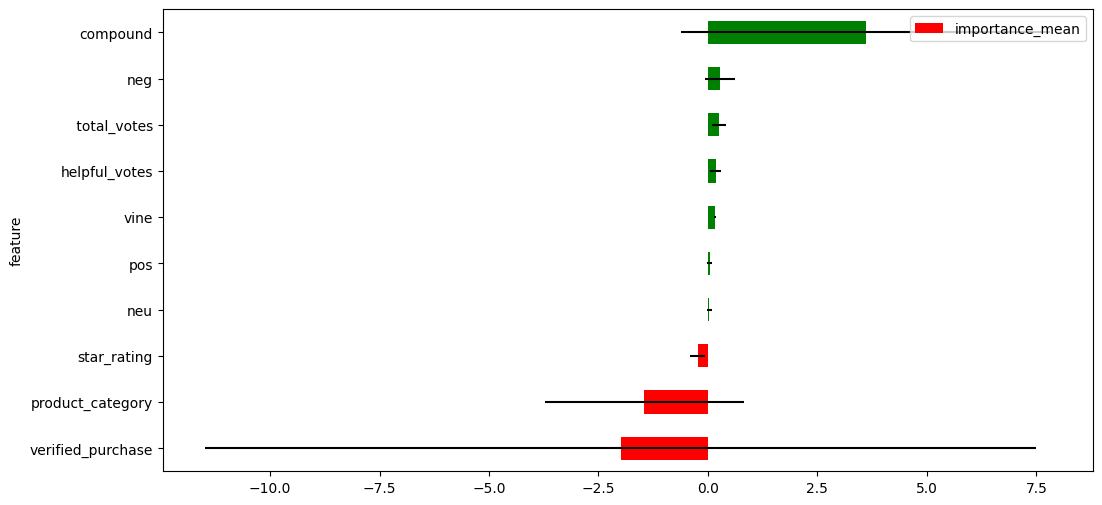

In [ ]:
# Initialize LOFOImportance with the dataset and model
lr_lofo_imp = LOFOImportance(dataset, model=lr_model, scoring="neg_mean_squared_error")
# Compute the importances
lr_importance_df = lr_lofo_imp.get_importance()
# Visualize the feature importances
plot_importance(lr_importance_df, figsize=(12, 6))

### Ridge Regression

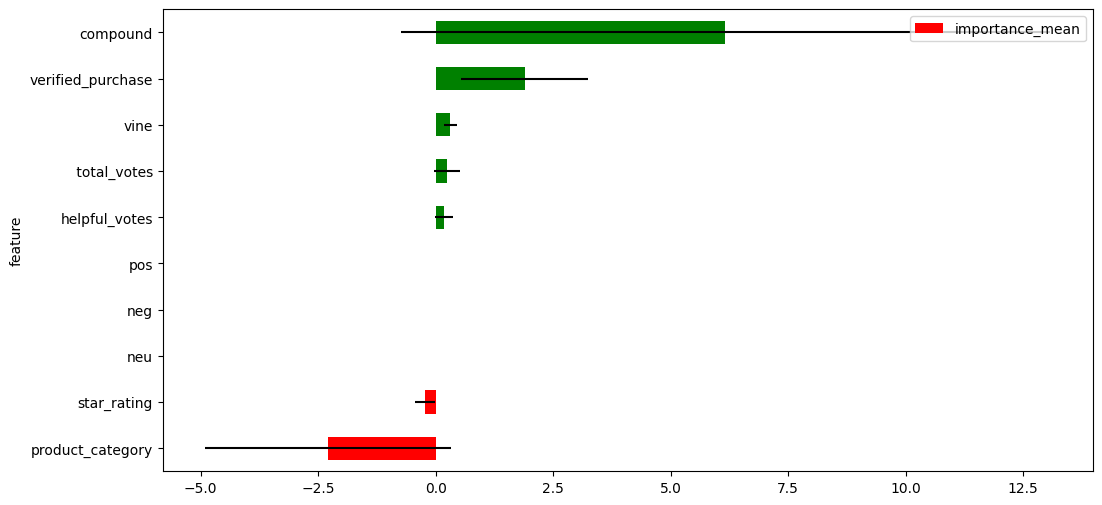

In [ ]:
# Initialize LOFOImportance with the dataset and model
ridge_lofo_imp = LOFOImportance(dataset, model=ridge_model, scoring="neg_mean_squared_error")
# Compute the importances
ridge_importance_df = ridge_lofo_imp.get_importance()
# Visualize the feature importances
plot_importance(ridge_importance_df, figsize=(12, 6))

### Lasso Regression

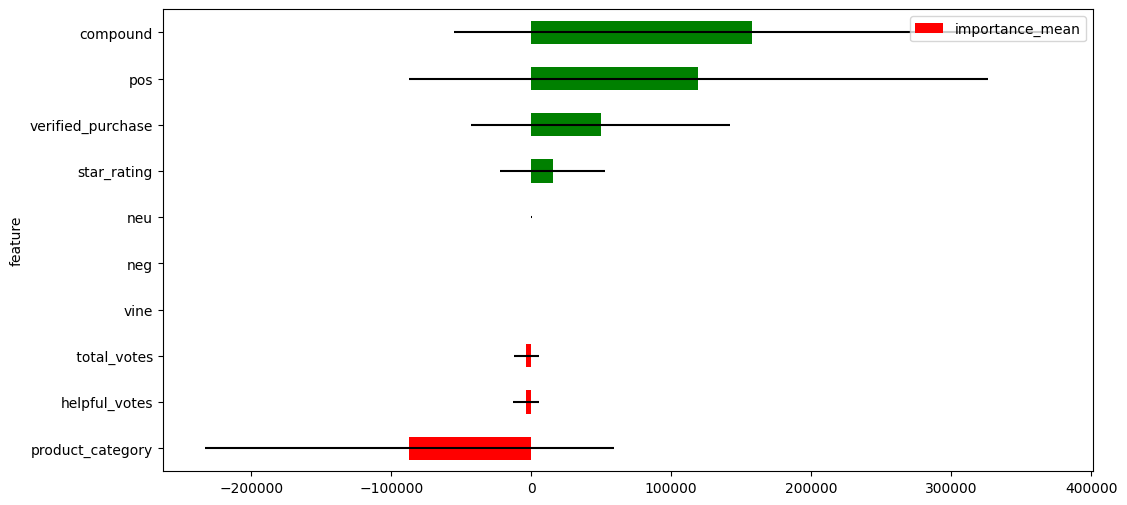

In [ ]:
# Initialize LOFOImportance with the dataset and model
lasso_lofo_imp = LOFOImportance(dataset, model=lasso_model, scoring="neg_mean_squared_error")
# Compute the importances
lasso_importance_df = lasso_lofo_imp.get_importance()
# Visualize the feature importances
plot_importance(lasso_importance_df, figsize=(12, 6))

### RandomForest Regression

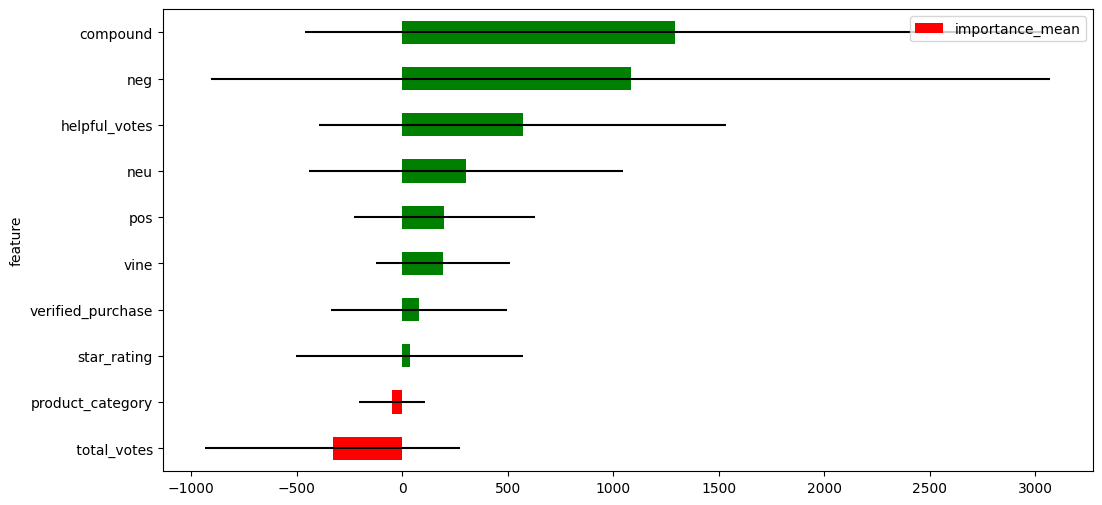

In [ ]:
# Initialize LOFOImportance with the dataset and model
rfr_lofo_imp = LOFOImportance(dataset, model=rfr_model, scoring="neg_mean_squared_error")
# Compute the importances
rfr_importance_df = rfr_lofo_imp.get_importance()
# Visualize the feature importances
plot_importance(rfr_importance_df, figsize=(12, 6))

# Compare Performance

In [ ]:
models = [lr_model, ridge_model, lasso_model, rfr_model]

In [ ]:
results = {'Model': [], 'MAE': [], 'MSE': [], 'R2': []}

for model in models:
    model.fit(X_train, y_train)
    predicts = model.predict(X_test)
    results['Model'].append(model.__class__.__name__)
    results['MAE'].append(mean_absolute_error(y_pred=predicts, y_true=y_test))
    results['MSE'].append(mean_squared_error(y_pred=predicts, y_true=y_test))
    results['R2'].append(r2_score(y_pred=predicts, y_true=y_test))

In [ ]:
results = pd.DataFrame(results)
results

,Model,MAE,MSE,R2
0,LinearRegression,7.660280,623.179087,0.053894
1,Ridge,7.659763,623.176315,0.053898
2,Lasso,7.577031,624.415554,0.052017
3,RandomForestRegressor,7.963675,692.318261,0.051073


In [ ]:
results.to_csv('output/results.csv')